# 3. Exp√©rimentation et comparaison des architectures RNN

### Introduction

Ce notebook a pour objectif de **d√©finir les fonctions n√©cessaires √† l‚Äôentra√Ænement des mod√®les**, ainsi que de **sauvegarder automatiquement les r√©sultats** :

- Les **graphiques** g√©n√©r√©s seront enregistr√©s dans le dossier `/figures`
- Les **tableaux de r√©sultats** seront enregistr√©s dans le dossier `/results`

En fin de notebook, un **bloc principal** ex√©cutera les diff√©rentes fonctions avec les **param√®tres choisis**, afin de lancer les entra√Ænements.

L‚Äôobjectif est de pouvoir tester facilement **plusieurs configurations de mod√®les** et d‚Äôenregistrer **syst√©matiquement les r√©sultats** pour une analyse future.

L‚Äôanalyse d√©taill√©e des performances sera effectu√©e dans le dernier notebook : [Analyse des r√©sultats](./04_evaluation_et_analyse.ipynb)


### Import des biblioth√®ques

In [76]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
import tensorflow as tf

Sequential = tf.keras.models.Sequential
SimpleRNN = tf.keras.layers.SimpleRNN
LSTM = tf.keras.layers.LSTM
GRU = tf.keras.layers.GRU
Dense = tf.keras.layers.Dense
Dropout = tf.keras.layers.Dropout
Bidirectional = tf.keras.layers.Bidirectional
EarlyStopping = tf.keras.callbacks.EarlyStopping
Adam = tf.keras.optimizers.Adam
Input = tf.keras.Input


### D√©finition des param√®tres qui seront utilis√©s pour l'entra√Ænement

In [77]:
UNITS = None
DROPOUT = None
STACKED = None
USE_BIDIRECTIONAL = None
AJOUTER_BRUIT = None
BRUIT_SIGMA = None        

### Initialisation de la taille de fen√™tre constante

In [78]:
WINDOW_SIZE = 14

### Fonction de chargement des datasets de train, validation et test

In [79]:
def load_dataset(path,ajouter_bruit=False, sigma=0.05):
    df = pd.read_csv(path, header=None)
    data = df.values
    X = data[:, :-1]
    y = data[:, -1]

    X = X[..., np.newaxis]  # forme (samples, window, 1)

    if ajouter_bruit:
        bruit = np.random.normal(0, sigma, size=X.shape)
        X += bruit

    return X, y

X_train, y_train = load_dataset("../data/TrainDataSet.csv", ajouter_bruit=AJOUTER_BRUIT, sigma=BRUIT_SIGMA)
X_val, y_val = load_dataset("../data/ValidationDataSet.csv")
X_test, y_test = load_dataset("../data/TestDataSet.csv")

### Sauvegarde des diff√©rents r√©sultats

#### R√©cuperer les param√®tres pour dinstinguer les images et tableaux

In [80]:
def get_param_suffix():
    return (
        f"WS{WINDOW_SIZE}"
        f"_U{UNITS}"
        f"_DO{int(DROPOUT * 100)}"
        f"_{'STACKED' if STACKED else 'SINGLE'}"
        f"_{'BIDIR' if USE_BIDIRECTIONAL else 'UNIDIR'}"
    )

#### Enregistrement des images

In [81]:
def titre_to_filename(titre, dossier="figures", suffix=""):
    if suffix:
        titre += f"__{suffix}"

    nom_fichier = titre + ".png"

    racine_projet = os.path.abspath(os.path.join(os.getcwd(), ".."))
    chemin_figures = os.path.join(racine_projet, dossier)
    os.makedirs(chemin_figures, exist_ok=True)

    return os.path.join(chemin_figures, nom_fichier)

#### Enregistrement des tableaux

In [82]:
def enregistrer_dataframe(df, base_filename="comparaison_performances", dossier="results"):
    suffix = get_param_suffix()
    nom_fichier = f"{base_filename}_{suffix}.csv"

    # Cr√©e le dossier dans la racine du projet
    racine_projet = os.path.abspath(os.path.join(os.getcwd(), ".."))
    chemin_dossier = os.path.join(racine_projet, dossier)
    os.makedirs(chemin_dossier, exist_ok=True)

    chemin_complet = os.path.join(chemin_dossier, nom_fichier)
    df.to_csv(chemin_complet, index=False)

### Construction du mod√®le

In [83]:
def build_model(rnn_type="SimpleRNN"):
    model = Sequential()
    rnn_layer = None
    model.add(Input(shape=(WINDOW_SIZE, 1)))


    return_sequences = STACKED

    # Cr√©ation de la couche RNN
    if rnn_type == "SimpleRNN":
        rnn_layer = SimpleRNN(UNITS, return_sequences=return_sequences)
    elif rnn_type == "LSTM":
        rnn_layer = LSTM(UNITS, return_sequences=return_sequences)
    elif rnn_type == "GRU":
        rnn_layer = GRU(UNITS, return_sequences=return_sequences)

    # Bidirectionnal
    if USE_BIDIRECTIONAL:
        model.add(Bidirectional(rnn_layer))
    else:
        model.add(rnn_layer)

    # Deuxi√®me couche RNN si empilement activ√©
    if STACKED:
        if rnn_type == "SimpleRNN":
            model.add(SimpleRNN(UNITS))
        elif rnn_type == "LSTM":
            model.add(LSTM(UNITS))
        elif rnn_type == "GRU":
            model.add(GRU(UNITS))

    # Couche de sortie
    model.add(Dropout(DROPOUT))
    model.add(Dense(1))  # Sortie de r√©gression

    return model


### Compilation et Entra√Ænement

In [84]:
def compile_and_train(model, X_train, y_train, X_val, y_val):
    model.compile(loss='mse', optimizer=Adam(), metrics=['mae'])
    early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=500,
        batch_size=32,
        callbacks=[early_stop],
        verbose=0
    )

    # Affichage de la courbe d'apprentissage
    plt.figure(figsize=(8, 4))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(f"Courbe de perte - {model.name}")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)

    suffix = get_param_suffix()
    filename = titre_to_filename(f"Courbe_de_perte_{model.name}", dossier="figures", suffix=suffix)
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()

    return model

### √âvaluation du mod√®le

In [85]:
def evaluate_model(model, X_test, y_test, name):
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mse)

    print(f"{name} - MSE: {mse:.4f}, MAE: {mae:.4f}, RMSE: {rmse:.4f}")

    # Visualisation des pr√©dictions
    plt.figure(figsize=(10, 4))
    plt.plot(y_test, label='R√©el')
    plt.plot(y_pred, label='Pr√©dit')
    plt.title(f"R√©el vs Pr√©dit - {name}")
    plt.legend()
    plt.grid(True)
    suffix = get_param_suffix()
    filename = titre_to_filename(f"Reel_vs_Predit_{name}", dossier="figures", suffix=suffix)
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()

    return {"Mod√®le": name, "MSE": mse, "MAE": mae, "RMSE": rmse}

### Boucle principale d'exp√©rimentation

In [86]:
def train_and_evaluate_all_models():
    results = []
    trained_models = {}

    for rnn_type in ["SimpleRNN", "LSTM", "GRU"]:
        print(f"\n===== Entra√Ænement du mod√®le : {rnn_type} =====")
        model = build_model(rnn_type)
        model.name = rnn_type
        model = compile_and_train(model, X_train, y_train, X_val, y_val)

        metrics = evaluate_model(model, X_test, y_test, rnn_type)
        results.append(metrics)
        trained_models[rnn_type] = model

    return results, trained_models



### Tableau comparatif final

In [87]:
def afficher_comparaison_des_performances(results):
    results_df = pd.DataFrame(results)
    print("\nComparaison des performances :")
    print(results_df)
    
    enregistrer_dataframe(results_df)


### Visualisation comparaison des pr√©dictions

In [ ]:
def afficher_predictions_detaillees(trained_models,N=100, vmin=6, vmax=38.71):
    plt.figure(figsize=(14, 6))

    # D√©normalisatioR√©sultaRRRrdsqfdsfsdsfsdffQSDFSssssssdes valeurs r√©elles
    y_test_denorm = y_test[:N] * (vmax - vmin) + vmin
    plt.plot(y_test_denorm, label="Valeurs r√©elles (¬∞C)", linewidth=2)

    for name, model in trained_models.items():
        y_pred = model.predict(X_test)
        # D√©normalisation des pr√©dictions
        y_pred_denorm = y_pred[:N].flatten() * (vmax - vmin) + vmin
        plt.plot(y_pred_denorm, label=f"Pr√©dictions {name} (¬∞C)")

    titre = "Comparaison_des_predictions_vs_r√©el"
    plt.title(titre)
    plt.xlabel("Temps")
    plt.ylabel("Temp√©rature (¬∞C)")
    plt.legend()
    plt.grid(True)

    suffix = get_param_suffix()
    filename = titre_to_filename(titre, dossier="figures", suffix=suffix)
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()


### Experimentation avec les param√®tres modifiables

C‚Äôest ici que nous allons entra√Æner nos mod√®les en faisant varier les diff√©rents param√®tres.
Les graphiques et tableaux seront affich√©s dans la sortie (output), mais, comme expliqu√© pr√©c√©demment, ils seront √©galement enregistr√©s pour une analyse future.


===== Entra√Ænement du mod√®le : SimpleRNN =====


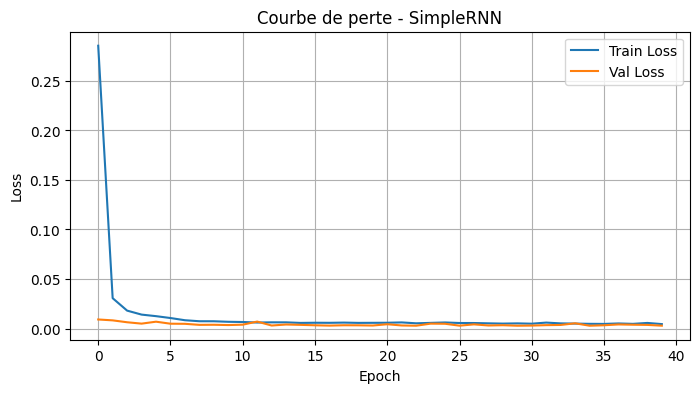

8/8 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 32ms/step
SimpleRNN - MSE: 0.0021, MAE: 0.0360, RMSE: 0.0459


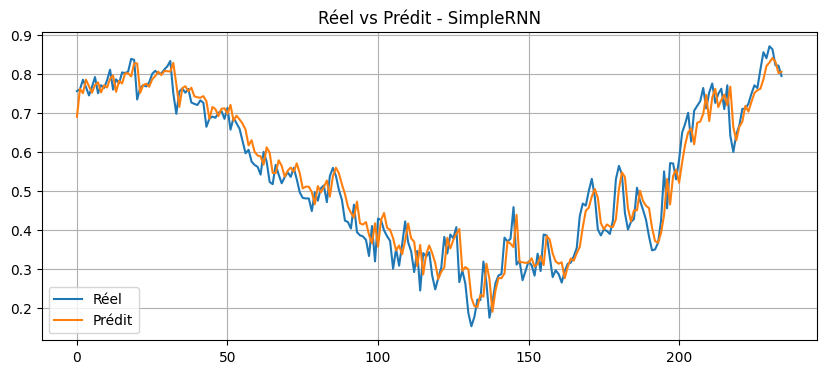


===== Entra√Ænement du mod√®le : LSTM =====


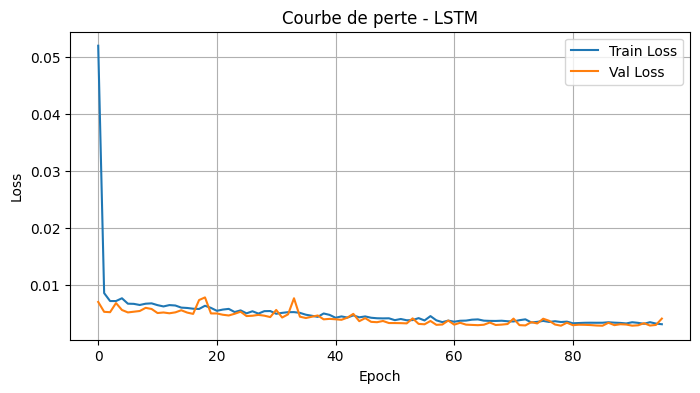

8/8 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 50ms/step
LSTM - MSE: 0.0021, MAE: 0.0358, RMSE: 0.0453


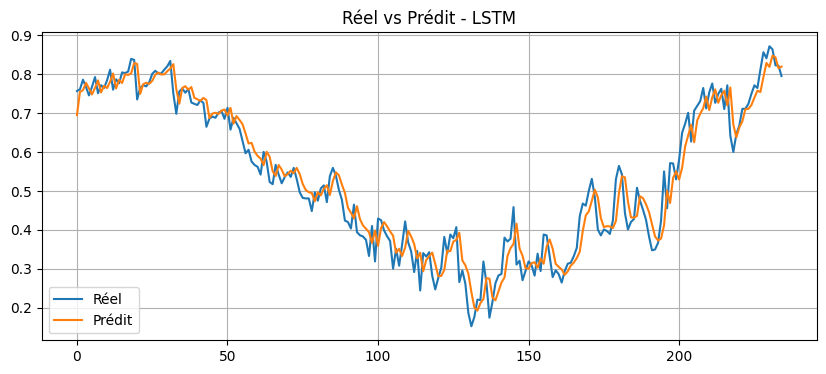


===== Entra√Ænement du mod√®le : GRU =====


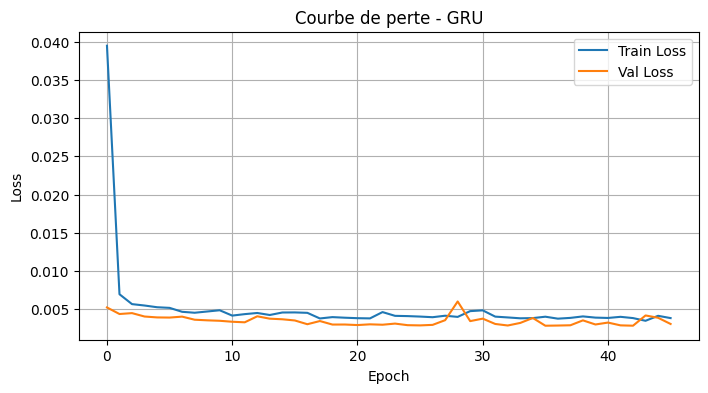

8/8 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 54ms/step
GRU - MSE: 0.0020, MAE: 0.0351, RMSE: 0.0446


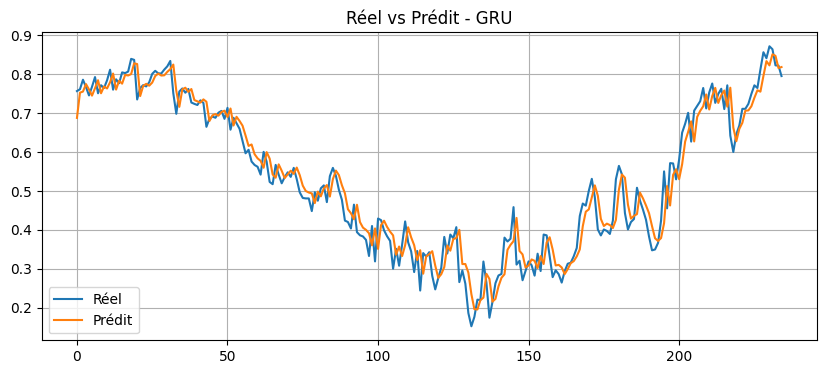

8/8 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 7ms/step 
8/8 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 8ms/step 
8/8 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 10ms/step


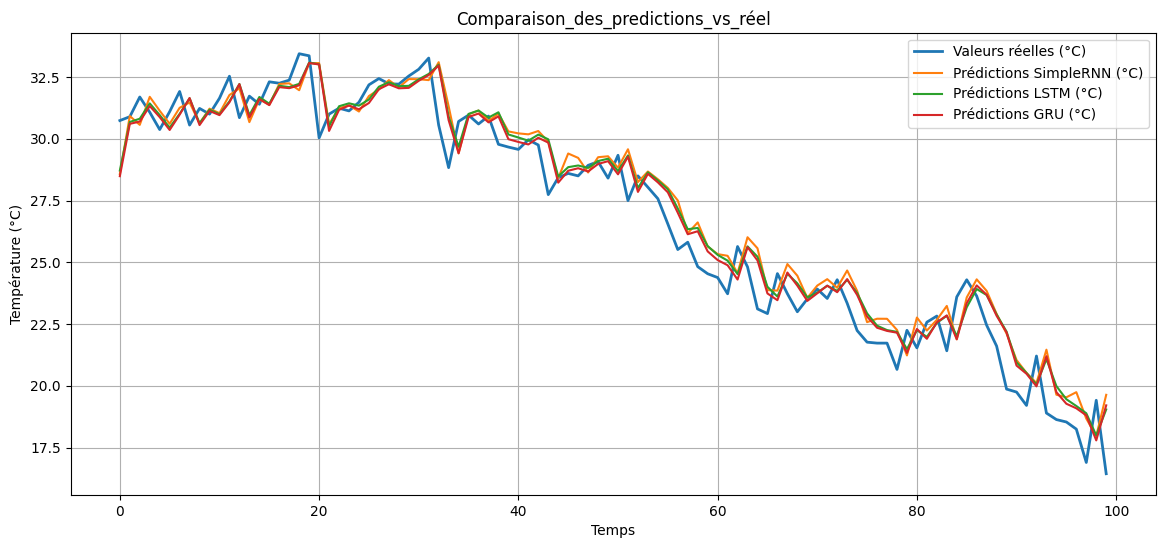


Comparaison des performances :
      Mod√®le       MSE       MAE      RMSE
0  SimpleRNN  0.002105  0.036014  0.045884
1       LSTM  0.002055  0.035850  0.045337
2        GRU  0.001993  0.035091  0.044643


In [89]:
UNITS = 64
DROPOUT = 0.2
STACKED = True
USE_BIDIRECTIONAL = False
AJOUTER_BRUIT = False
BRUIT_SIGMA = 0.0


results, trained_models = train_and_evaluate_all_models()

afficher_predictions_detaillees(trained_models=trained_models)

afficher_comparaison_des_performances(results)


**Dernier notebook : Entrainement et compilation du mod√®le**

üëâ [Aller au dernier Notebook](./04_evaluation_et_analyse.ipynb)